# Global reconstruction

Aim: Look into global and regional reconstructions for temperature and precipitation

Anomaly/No anomaly, R=0.5, reuse, ts=[1,5,10,20,40]:
    - frac/no frac
Anomaly/No anomaly, R=0.1 (more weight to proxies!), no reuse, ts=[1,5,10,20,40]:
    - frac/no frac

- variables: prec/tsurf/evap/slp (when available!)
- anomaly period: 1600-1800
- models: all five, joined_giss, joined_nogiss
- Monte Carlo: 1 single repetition (100 ensemble members should be enough)

Aim: 
- Find consisten patterns between models for global and regional patterns (Europe+Greenland and the Amazon regiion)
- does the fractionation really make results inconsistent?

    
Afterwards:
- compare these spatial regions to PHYDA (especially for the amazon there is a clear lack)
- Choose one good mode (I think of anomaly, R=0.5, reuse, ts=[1,5,10,20,40]) and for this mode do particular reconstructions: Only with proxies from the region, only icecores/speleothems, look into the influence of carabean proxies into the amazon pattern).



In [1]:
cfg = {
#BASIC PARAMS
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'oro': None,
'reconstruct':['tsurf','d18O','prec'], 
'output_folder':'GMT_from_allproxies_normalres', #in cwd
'output_file':'Echam_1_10_20',
'multi_model_prior': None, #None or a list where the first entry is a dictionary of dictionaries for the file paths and secord a dictionary with the orography files
'avg':None, 
'seed': 42, 
'check_nan':False, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
###PROXYS
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1600_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1600_1800.nc'],
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']],#,['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1,0.1], #irrelevant for PPE
'time_scales': ['median'], 
'proxy_time':['0800','1999'], 
    only_regional_proxies'
'resample': True,#True,
'resample_mode': 'linear',#'nearest',
'mask': 3, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20,40], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
#'timescales':[1],
'timescales':[1,5,10,20,40],
'reuse': True,#True, #e.g if a yearly resolved proxy is also to be used in the 5,10 year mean reconstruction
###PSM
'psm':['speleo','icecore'], 
'interpol':None, #None/'dw'
'var_psm': ['d18O','d18O'] ,
'speleo':{
    'weighting': None,#'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation': False, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting':None, #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},
#currently this only works for one Database files, probably at some point that needs to be more flexible
'linear':{
    'variable': 'tsurf' , #variable to regress against
    'type': 'anom' , #absolute value or anomaly
    'anom_time': None , #None for full simulation, or time-list 
    'uniform': None, # if you just want one linear formula to rule them all [slope, intercept]
    #names of the regression parameters in the proxy-db
    'slope': 'slope' ,
    'intercept': 'intercept',
    'error': 'error', #make sure that the error in the database info is really the regression error *variance*, not standard error.
},
###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': False,
    'SNR': [5,5], #signal to noise variance ratio
    'noise_type': 'w', #'w'/'r'
    'red_noise_a': 0.32, #autocorrelation for red noise
    'multi_timescale': [[1],[1]], 
    'source': 'external', #internal/external
    'other_model': 
    {'vp':{'tsurf':'/home/ldap-server/draco/cleaned_data/final/CESM_tsurf_850_1850.nc',
    'prec':'/home/ldap-server/draco/cleaned_data/final/CESM_prec_850_1850.nc',
    'd18O':'/home/ldap-server/draco/cleaned_data/final/CESM_d18O_850_1850.nc',
    'evap': '/home/ldap-server/draco/cleaned_data/final/CESM_evap_850_1850.nc'}},
    'oro': '/home/ldap-server/draco/orographies/final/icesm_oro.nc',
    'metrics_ppe': ['Corr','p_value','p_bootstrap','eff_p_value','CE','RMSE','RMSPE','MAE','MAPE'],
    'psm' : {'speleo':{   'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}, 'icecore': None},
},
    # cfg['ppe']['psm']= {'speleo':None, 'icecore': None} # if the config from above for the psm (which gives the obs-from-model) shall be different for the pseudoproxies.
#else just leave it as {'speleo':None, 'icecore': None} 
    
###KALMAN-FILTER
'time': ['0800','1999'], #covered by all models
'nens':100, #ensemble members
'reps':1, #Monte Carlo
'full_fields': True, 
'proxy_frac': None, #choose 100 random proxies
'extra_assi': 
    {
        'globalmean': ['tsurf','d18O','prec'], #None or list of variables
        'lat_mean': ['tsurf'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': 'BG+HX', #/ 'HX'
'anomaly_time': ['1600','1800'],#None,#['1500','1750'],#None,
'cov_loc': None,
#evaluation metrics (which do not rely on a true state)
'metrics': [None],#['rank_histogram','rank_histogram_posterior','CD'], #['None']
}

In [ ]:
cfg['ppe']['noise_before_filt']= #The noise is added before filtering

In [21]:
normal_paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc',
       }
}

upsampled_paths_nogiss=[{
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_tsurf_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_slp_801_1952.nc',
       }
},{
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/hadcm3_oro.nc',
'iCESM':'/home/mchoblet/paleoda/data/orographies/icesm_oro.nc',
}]

upsampled_paths=[{
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/upsampled/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_slp_801_1952.nc',
       }
},{
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/upsampled/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/upsampled/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/upsampled/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/upsampled/hadcm3_oro.nc',
'iCESM':'/home/mchoblet/paleoda/data/orographies/upsampled/icesm_oro.nc',
}]



oro_dic={
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/hadcm3_oro.nc',
'iCESM':'/home/mchoblet/paleoda/data/orographies/icesm_oro.nc',
}
"""
oro_dic_up={
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/upsampled/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/upsampled/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/upsampled/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/upsampled/hadcm3_oro.nc',
'iCESM':'/home/mchoblet/paleoda/data/orographies/upsampled/icesm_oro.nc',
}

oro_dic_up_nogiss={
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/upsampled/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/upsampled/echam_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/upsampled/hadcm3_oro.nc',
'iCESM':'/home/mchoblet/paleoda/data/orographies/upsampled/icesm_oro.nc',
}
"""

"\noro_dic_up={\n    'isoGSM':'/home/mchoblet/paleoda/data/orographies/upsampled/ccsm_oro.nc',\n'Echam': '/home/mchoblet/paleoda/data/orographies/upsampled/echam_oro.nc',\n'GISS':'/home/mchoblet/paleoda/data/orographies/upsampled/giss_oro.nc',\n'iHadCM3':'/home/mchoblet/paleoda/data/orographies/upsampled/hadcm3_oro.nc',\n'iCESM':'/home/mchoblet/paleoda/data/orographies/upsampled/icesm_oro.nc',\n}\n\noro_dic_up_nogiss={\n    'isoGSM':'/home/mchoblet/paleoda/data/orographies/upsampled/ccsm_oro.nc',\n'Echam': '/home/mchoblet/paleoda/data/orographies/upsampled/echam_oro.nc',\n'iHadCM3':'/home/mchoblet/paleoda/data/orographies/upsampled/hadcm3_oro.nc',\n'iCESM':'/home/mchoblet/paleoda/data/orographies/upsampled/icesm_oro.nc',\n}\n"

In [3]:
import sys
sys.path.append('/home/mchoblet/paleoda')

import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils

import copy

%load_ext autoreload
%autoreload 2

In [30]:
def global_recon(cfg,name):
    """
    In each folder there will be 14=7*(models/mme) * 2 (ano/_no_ano) files.
    Each files contains the reconstructions for 4/5 variables (tsurf,prec,d18O,evap,slp)
    The timescales are set to 1,5,10,20,40
    """
    cfg['timescales']=[1,5,10,20,40]
    cfg['obsdata']=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1600_1800.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1600_1800.nc']
    cfg['resample_mode']='linear'
    cfg['mask']=3 
    cfg['var_psm']= ['d18O','d18O'] 
    cfg['psm']=['speleo','icecore'] 
    cfg['interpol']= None 
    cfg['extra_assi']={
        'globalmean': ['tsurf','d18O','prec'], #None or list of variables
        'lat_mean': ['tsurf','prec'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    }
    cfg['error_scale']=1 
    
    
    for i in range(2):
        #turn on/off anomaly
        if i==0:
            cfg['anomaly']='BG+HX'
            cfg['anomaly_time']=['1600','1800']
            cfg['output_file']=name+'_ano'
            cfg['speleo']['height']=False
            cfg['icecore']['height']=False
        else:
            cfg['anomaly']=None
            cfg['output_file']=name+'_abs'
            cfg['speleo']['height']=True
            cfg['icecore']['height']=False
            cfg['speleo']['weighting']='inf'
            cfg['icecore']['weighting']='prec'
        
        #no frac, r=0.5, reuse
        cfg['output_folder']='800_1999_nofrac_reuse'
        cfg['proxy_error']= [0.5,0.5]
        cfg['speleo']['fractionation']=False
        cfg['reuse']=True
        wrapper.paleoda_wrapper(cfg)
        
        #no frac, r=0.1, no reuse
        cfg['output_folder']='800_1999_nofrac_noreuse'
        cfg['proxy_error']= [0.1,0.1]
        cfg['reuse']=False
        wrapper.paleoda_wrapper(cfg)
        
        #frac, r=0.5, reuse
        cfg['output_folder']='800_1999_frac_reuse'
        cfg['proxy_error']= [0.5,0.5]
        cfg['speleo']['fractionation']=True
        cfg['fractionation_temp']='regular'
        cfg['reuse']=True
        wrapper.paleoda_wrapper(cfg)
        
        #frac, r=0.1, no reuse
        cfg['output_folder']='800_1999_frac_noreuse'
        cfg['speleo']['fractionation']=True
        cfg['fractionation_temp']='regular'
        cfg['proxy_error']= [0.1,0.1]
        cfg['reuse']=False
        wrapper.paleoda_wrapper(cfg)

In [31]:
def loop_models(cfg,paths):
    names=list(paths.keys())
    #loop over five models:
    for na in names:
        cfg['vp']=paths[na]
        cfg['reconstruct']=list(paths[na].keys())
        cfg['oro']=oro_dic[na]
        global_recon(cfg,na)
    
    cfg['reconstruct']=['tsurf','prec','d18O','evap']
    #mme(upsampled)
    cfg['multi_model_prior']=upsampled_paths
    global_recon(cfg,'mme')
    
    #mme(no-giss)
    cfg['multi_model_prior']=upsampled_paths_nogiss
    global_recon(cfg,'mme_nogiss')

In [32]:
loop_models(cfg,normal_paths)

>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.36it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [02:37<00:00, 157.77s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.77it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [02:38<00:00, 158.77s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.38it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [02:38<00:00, 158.42s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.72it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [02:39<00:00, 159.26s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:11<00:00,  9.23it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [02:40<00:00, 160.10s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.69it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [02:39<00:00, 159.78s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.40it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [02:40<00:00, 160.92s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.53it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [02:39<00:00, 159.72s/it]


Finished multitimescale DA
Save variables
Output written to iCESM_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.37it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:27<00:00, 207.42s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.66it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:25<00:00, 205.88s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.53it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:26<00:00, 206.22s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.38it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:27<00:00, 207.33s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:11<00:00,  9.32it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:27<00:00, 207.50s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.68it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:26<00:00, 206.38s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.39it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:25<00:00, 205.82s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.69it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:26<00:00, 206.14s/it]


Finished multitimescale DA
Save variables
Output written to isoGSM_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:11<00:00,  9.29it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [00:50<00:00, 50.20s/it]


Finished multitimescale DA
Save variables
Output written to Echam_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.81it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [00:50<00:00, 50.70s/it]


Finished multitimescale DA
Save variables
Output written to Echam_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.38it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [00:50<00:00, 50.86s/it]


Finished multitimescale DA
Save variables
Output written to Echam_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.77it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [00:50<00:00, 50.32s/it]


Finished multitimescale DA
Save variables
Output written to Echam_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.46it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [00:50<00:00, 50.12s/it]


Finished multitimescale DA
Save variables
Output written to Echam_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.74it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [00:50<00:00, 50.17s/it]


Finished multitimescale DA
Save variables
Output written to Echam_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.46it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [00:50<00:00, 50.70s/it]


Finished multitimescale DA
Save variables
Output written to Echam_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.95it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [00:50<00:00, 50.00s/it]


Finished multitimescale DA
Save variables
Output written to Echam_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:11<00:00,  9.36it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:06<00:00, 186.48s/it]


Finished multitimescale DA
Save variables
Output written to GISS_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.64it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:06<00:00, 186.24s/it]


Finished multitimescale DA
Save variables
Output written to GISS_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.45it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:06<00:00, 186.52s/it]


Finished multitimescale DA
Save variables
Output written to GISS_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.51it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:06<00:00, 186.09s/it]


Finished multitimescale DA
Save variables
Output written to GISS_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.40it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:06<00:00, 186.61s/it]


Finished multitimescale DA
Save variables
Output written to GISS_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.73it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:06<00:00, 186.34s/it]


Finished multitimescale DA
Save variables
Output written to GISS_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.39it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:07<00:00, 187.10s/it]


Finished multitimescale DA
Save variables
Output written to GISS_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.91it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [03:07<00:00, 187.07s/it]


Finished multitimescale DA
Save variables
Output written to GISS_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.45it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [01:31<00:00, 91.61s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.78it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [01:32<00:00, 92.10s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:11<00:00,  9.35it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [01:31<00:00, 91.93s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.89it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [01:31<00:00, 91.98s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_ano.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:11<00:00,  9.31it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [01:32<00:00, 92.12s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.72it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [01:31<00:00, 91.71s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.37it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [01:32<00:00, 92.03s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:05<00:00, 19.78it/s]


Load d18O  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc
computing yearly average
Load slp  from  /home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
use time-varying temperature
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: None
Compute anomaly for proxies
Start Multitimescale DA loop.


100%|██████████| 1/1 [01:31<00:00, 91.76s/it]


Finished multitimescale DA
Save variables
Output written to iHadCM3_abs.nc
>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 103/103 [00:10<00:00,  9.42it/s]


Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING ICECORE PSM
COMPUTE ANOMALIES IN MODE: BG+HX


KeyError: 'slp'

In [6]:
iso2k=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db_1600_1800.nc')

In [16]:
sites=iso2k['d18O'].where((iso2k['d18O'].lat>75) & (iso2k.lon>10)& (iso2k.lon<25),drop=True)

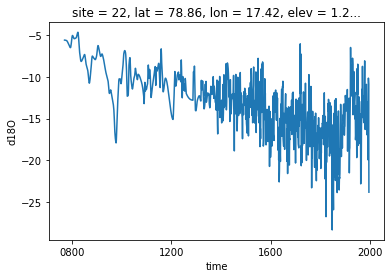

In [18]:
sites[:,0].plot()

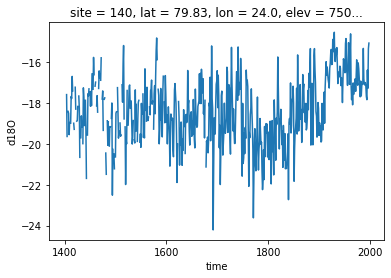

In [19]:
sites[:,1].plot()